=== 사용자별 세션 개수/길이 통계 ===
            num_sess       mean_len        max_len
count  322897.000000  322897.000000  322897.000000
mean        3.447028       2.490210       3.149797
std         4.317101       0.853169       1.886410
min         1.000000       1.142857       2.000000
25%         1.000000       2.000000       2.000000
50%         2.000000       2.000000       3.000000
75%         4.000000       2.800000       4.000000
max       136.000000      94.000000      94.000000


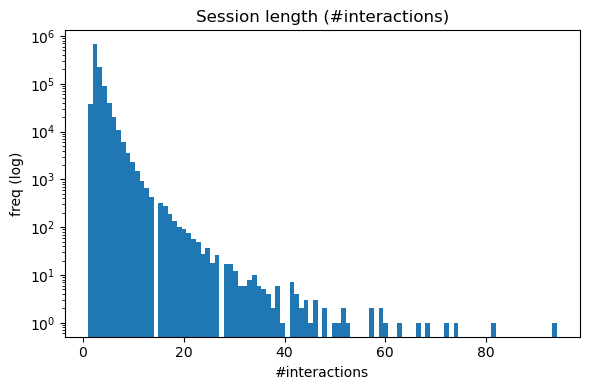

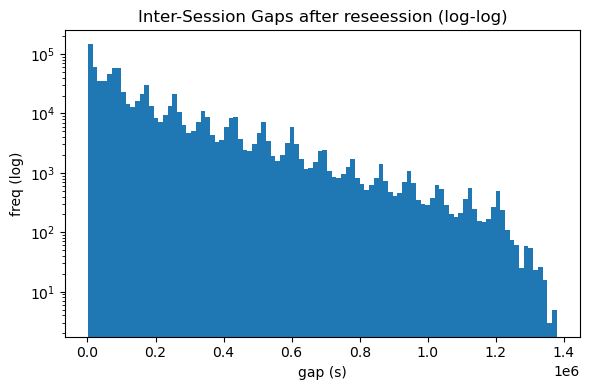

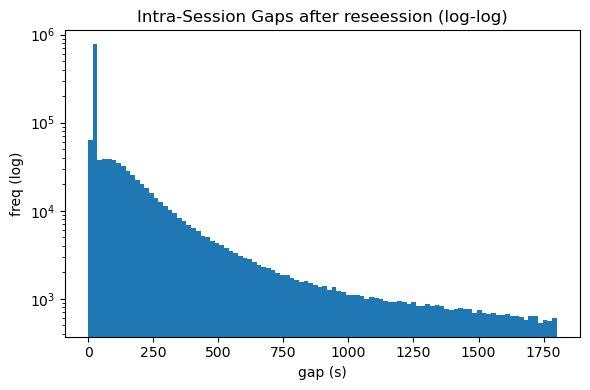

재세션화 결과 저장 완료 → /home/jy1559/Mar2025_Module/Datasets/Globo/interactions_revised_session.json


In [ ]:
# ===============================================
import json, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Tuple, Dict

JSON_PATH = "/home/jy1559/Mar2025_Module/Datasets/Globo/interactions_revised.json"          # <-- 데이터셋 경로
OUT_PATH = "/home/jy1559/Mar2025_Module/Datasets/Globo/interactions_revised_session.json"          # <-- 데이터셋 경로
THETA       = 1800               # 2 h = 7 200 sec

# ────────────────────────────────────────────────────────────
def load_raw(path: str) -> Dict[str, List]:
    with open(path, "r", encoding="utf-8") as f:
        raw = json.load(f)
    return raw["data"]

def split_sessions_sorted(interactions: List[Tuple], theta: int = 7200):
    """
    interactions: [(item_id, ts, extra…), …]  ─ 이미 시간순 정렬된 리스트
    theta      : Δt 초 (>= theta 면 새 세션)
    return     : List[List[Tuple]]  (세션 리스트)
    """
    if not interactions:
        return []
    sessions, cur = [], [interactions[0]]
    for prev, nxt in zip(interactions, interactions[1:]):
        if nxt[1] - prev[1] >= theta:
            sessions.append(cur)
            cur = [nxt]
        else:
            cur.append(nxt)
    sessions.append(cur)
    return sessions

def reseession_all(data: Dict[str, List], theta: int = 7200):
    new_data, stats = {}, []
    for uid, sess_list in data.items():
        # ① 모든 interaction 한 줄로 모아 정렬
        flat = [it for sess in sess_list for it in sess]
        flat.sort(key=lambda x: x[1])

        # ② 새 세션 분할
        new_sess = split_sessions_sorted(flat, theta)

        new_data[uid] = new_sess
        stats.append(
            dict(user_id=uid,
                 num_sess=len(new_sess),
                 mean_len=np.mean([len(s) for s in new_sess]),
                 max_len=max(len(s) for s in new_sess))
        )
    return new_data, pd.DataFrame(stats)

# ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    raw_data = load_raw(JSON_PATH)

    new_data, user_stats = reseession_all(raw_data, THETA)
    print("=== 사용자별 세션 개수/길이 통계 ===")
    print(user_stats.describe())

    # 전체 세션 길이·inter-gap 히스토그램 (옵션)
    all_lens, inter_gaps, intra_gaps = [], [], []
    for sess_list in new_data.values():
        all_lens.extend(len(s) for s in sess_list)
        for s_prev, s_next in zip(sess_list, sess_list[1:]):
            inter_gaps.append(s_next[0][1] - s_prev[-1][1])
            intra_gaps.extend(
                s_next[i][1] - s_next[i-1][1] for i in range(1, len(s_next))
            )

    plt.figure(figsize=(6, 4))
    plt.hist(all_lens, bins=100, log=True)
    plt.title("Session length (#interactions)")
    plt.xlabel("#interactions"); plt.ylabel("freq (log)")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(inter_gaps, bins=100, log=True)
    plt.title("Inter-Session Gaps after reseession (log-log)")
    plt.xlabel("gap (s)"); plt.ylabel("freq (log)")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(6, 4))
    plt.hist(intra_gaps, bins=100, log=True)
    plt.title("Intra-Session Gaps after reseession (log-log)")
    plt.xlabel("gap (s)"); plt.ylabel("freq (log)")
    plt.tight_layout(); plt.show()
    # 새 JSON 저장 (원래 구조 유지)
    with open(OUT_PATH, "w", encoding="utf-8") as f:
        json.dump({"data": new_data}, f)
    print(f"재세션화 결과 저장 완료 → {OUT_PATH}")
